# PPMI Gait Analysis
This data set is part of the Parkinson's Progression Markers Initiative. Anat Mirelman, PhD, of Tel Aviv University is the PI. According to the study summary: "The Gait study was proposed in order to obtain quantitative, objective motor measures that could
inform on pre-clinical symptoms, progression markers, and dynamic changes of function throughout disease and potential modifiers and mediators of motor symptoms."

My goals are to explore the data set to see if I can come up with an interesting clinical question, and to also improve my data science skills. One interesting question is to try and classify each subject according to these gait measures. The main categories of subjects are individuals who have a genetic marker for PD (e.g., LRRK2) but do not show signs of PD, and those who have a genetic marker and do have diagnoses of PD. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from datetime import datetime

from sklearn import preprocessing
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix, classification_report, precision_score

from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.model_selection import KFold

# This sets a higher resolution for figures
%config InlineBackend.figure_format = 'retina'

First, we need to import the necessary data sets. The Gait_Data data are the objective gait measures. The Screening data contain information on all > 600 individuals participating in PPMI.  

In [5]:
pd.options.display.max_rows = 1000
gait = pd.read_csv('Gait_Data___Arm_swing.csv')
screen_all = pd.read_csv('Screening___Demographics.csv')
updrs = pd.read_csv('MDS_UPDRS_Part_III.csv')
gait.columns

Index(['PATNO', 'EVENT_ID', 'INFODT', 'COHORT', 'SP_U', 'RA_AMP_U', 'LA_AMP_U',
       'RA_STD_U', 'LA_STD_U', 'SYM_U', 'R_JERK_U', 'L_JERK_U', 'ASA_U',
       'ASYM_IND_U', 'TRA_U', 'T_AMP_U', 'CAD_U', 'STR_T_U', 'STR_CV_U',
       'STEP_REG_U', 'STEP_SYM_U', 'JERK_T_U', 'SP__DT', 'RA_AMP_DT',
       'LA_AMP_DT', 'RA_STD_DT', 'LA_STD_DT', 'SYM_DT', 'R_JERK_DT',
       'L_JERK_DT', 'ASA_DT', 'ASYM_IND_DT', 'TRA_DT', 'T_AMP_DT', 'CAD_DT',
       'STR_T_DT', 'STR_CV_DT', 'STEP_REG_DT', 'STEP_SYM_DT', 'JERK_T_DT',
       'SW_VEL_OP', 'SW_PATH_OP', 'SW_FREQ_OP', 'SW_JERK_OP', 'SW_VEL_CL',
       'SW_PATH_CL', 'SW_FREQ_CL', 'SW_JERK_CL', 'TUG1_DUR', 'TUG1_STEP_NUM',
       'TUG1_STRAIGHT_DUR', 'TUG1_TURNS_DUR', 'TUG1_STEP_REG', 'TUG1_STEP_SYM',
       'TUG2_DUR', 'TUG2_STEP_NUM', 'TUG2_STRAIGHT_DUR', 'TUG2_TURNS_DUR',
       'TUG2_STEP_REG', 'TUG2_STEP_SYM'],
      dtype='object')

In [ ]:
screen_all.columns

From screening data, I only care about a few variables.

In [6]:
# 'PATNO', 'APPRDX', 'CURRENT_APPRDX', 'BIRTHDT', 'GENDER'
key_vars = ['PATNO', 'APPRDX', 'CURRENT_APPRDX', 'BIRTHDT', 'GENDER']
screen_filt = screen_all[key_vars]

For UPDRS Part III (motor scores), I only care about the 33 variables related to the testing instrument. 

In [7]:
updrs_vars = ['PATNO', 'INFODT', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'PN3RIGRL', 'NP3RIGLL', 
              'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 
              'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 
              'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 
              'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON']
updrs_filt = updrs[updrs_vars]
updrs_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PATNO     15832 non-null  int64  
 1   INFODT    15832 non-null  object 
 2   NP3SPCH   15832 non-null  int64  
 3   NP3FACXP  15832 non-null  int64  
 4   NP3RIGN   15829 non-null  float64
 5   NP3RIGRU  15829 non-null  float64
 6   NP3RIGLU  15829 non-null  float64
 7   PN3RIGRL  15827 non-null  float64
 8   NP3RIGLL  15826 non-null  float64
 9   NP3FTAPR  15830 non-null  float64
 10  NP3FTAPL  15827 non-null  float64
 11  NP3HMOVR  15830 non-null  float64
 12  NP3HMOVL  15826 non-null  float64
 13  NP3PRSPR  15830 non-null  float64
 14  NP3PRSPL  15828 non-null  float64
 15  NP3TTAPR  15799 non-null  float64
 16  NP3TTAPL  15802 non-null  float64
 17  NP3LGAGR  15831 non-null  float64
 18  NP3LGAGL  15830 non-null  float64
 19  NP3RISNG  15829 non-null  float64
 20  NP3GAIT   15830 non-null  fl

In [8]:
# Now I want to create new dataframe that only includes patients common to both gait and screen_filt
df_merged = pd.merge(gait, screen_filt, how='inner', on=['PATNO'])

# Did all of the subjects keep same diagnosis? If so, you can drop one of the dx columns 
print("Subjects kept same dx? " + str(sum(df_merged['APPRDX'] == df_merged['CURRENT_APPRDX']) == len(df_merged)))

# Let's drop some more columns
df_merged = df_merged.drop(columns=['CURRENT_APPRDX', 'EVENT_ID', 'COHORT'])

df_merged.columns

print(len(np.unique(df_merged['PATNO'])))
print(len(df_merged))

Subjects kept same dx? True
103
191


In [16]:
# keep track of the cols (excluding UDPRS scores) that we want to keep later when we drop rows based on NaNs
predictor_cols = ['SP_U', 'RA_AMP_U', 'LA_AMP_U', 'RA_STD_U',
       'LA_STD_U', 'SYM_U', 'R_JERK_U', 'L_JERK_U', 'ASA_U', 'ASYM_IND_U',
       'TRA_U', 'T_AMP_U', 'CAD_U', 'STR_T_U', 'STR_CV_U', 'STEP_REG_U',
       'STEP_SYM_U', 'JERK_T_U', 'SP__DT', 'RA_AMP_DT', 'LA_AMP_DT',
       'RA_STD_DT', 'LA_STD_DT', 'SYM_DT', 'R_JERK_DT', 'L_JERK_DT', 'ASA_DT',
       'ASYM_IND_DT', 'TRA_DT', 'T_AMP_DT', 'CAD_DT', 'STR_T_DT', 'STR_CV_DT',
       'STEP_REG_DT', 'STEP_SYM_DT', 'JERK_T_DT', 'SW_VEL_OP', 'SW_PATH_OP',
       'SW_FREQ_OP', 'SW_JERK_OP', 'SW_VEL_CL', 'SW_PATH_CL', 'SW_FREQ_CL',
       'SW_JERK_CL', 'TUG1_DUR', 'TUG1_STEP_NUM', 'TUG1_STRAIGHT_DUR',
       'TUG1_TURNS_DUR', 'TUG1_STEP_REG', 'TUG1_STEP_SYM', 'TUG2_DUR',
       'TUG2_STEP_NUM', 'TUG2_STRAIGHT_DUR', 'TUG2_TURNS_DUR', 'TUG2_STEP_REG',
       'TUG2_STEP_SYM']

# How many unique subjects are there? 
print(len(np.unique(gait['PATNO'])))
print(len(np.unique(df_merged['PATNO'])))
print(len(df_merged))
df_merged.head()
len(predictor_cols)

103
103
191


56

We want to create another data frame that contains data only from each patient's initial visit.

In [10]:
# We first need to format the dates correctly. Note that this method imputes day of month, but it doesn't matter
# since we only have month and year
df_merged['INFODATE'] = [datetime.strptime(x, '%m/%Y') for x in df_merged['INFODT']]

# Next we want to create new data frame with only first visit's data
df_baseline = df_merged.sort_values('INFODATE').groupby(['PATNO'], as_index=False).first()
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PATNO              103 non-null    int64  
 1   INFODT             103 non-null    object 
 2   SP_U               94 non-null     float64
 3   RA_AMP_U           94 non-null     float64
 4   LA_AMP_U           94 non-null     float64
 5   RA_STD_U           94 non-null     float64
 6   LA_STD_U           94 non-null     float64
 7   SYM_U              94 non-null     float64
 8   R_JERK_U           94 non-null     float64
 9   L_JERK_U           94 non-null     float64
 10  ASA_U              94 non-null     float64
 11  ASYM_IND_U         94 non-null     float64
 12  TRA_U              94 non-null     float64
 13  T_AMP_U            94 non-null     float64
 14  CAD_U              94 non-null     float64
 15  STR_T_U            94 non-null     float64
 16  STR_CV_U           94 non-

Let's figure out how many subjects were assessed on multiple visits.

In [ ]:
df_pts = df_merged.groupby('PATNO', as_index=False).count()
df_pts['MULT_VISITS'] = [1 if x > 1 else 0 for x in df_pts['INFODT']]
df_mult_visits = df_pts[df_pts['MULT_VISITS']==1]
print(len(df_mult_visits))

Uncomment next line if you want to print the current data frame.

In [ ]:
# df_baseline.to_csv('gait_baseline.csv', index=False)

Let's start to look at the data. 

In [11]:
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PATNO              103 non-null    int64  
 1   INFODT             103 non-null    object 
 2   SP_U               94 non-null     float64
 3   RA_AMP_U           94 non-null     float64
 4   LA_AMP_U           94 non-null     float64
 5   RA_STD_U           94 non-null     float64
 6   LA_STD_U           94 non-null     float64
 7   SYM_U              94 non-null     float64
 8   R_JERK_U           94 non-null     float64
 9   L_JERK_U           94 non-null     float64
 10  ASA_U              94 non-null     float64
 11  ASYM_IND_U         94 non-null     float64
 12  TRA_U              94 non-null     float64
 13  T_AMP_U            94 non-null     float64
 14  CAD_U              94 non-null     float64
 15  STR_T_U            94 non-null     float64
 16  STR_CV_U           94 non-

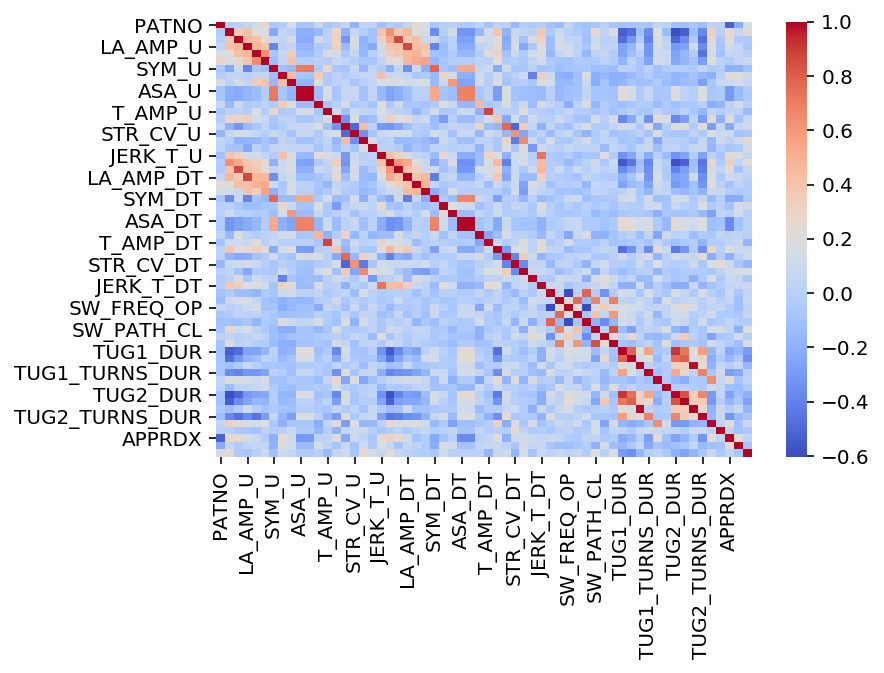

In [12]:
# Plot correlation matrix 
sns.heatmap(df_baseline.corr(),cmap='coolwarm')

In [ ]:
# Plot each variable against every other -- runtime is very slow, so don't include too much
sns.pairplot(df_baseline[['SP_U', 'RA_AMP_U', 
       'RA_STD_U', 'SYM_U', 'R_JERK_U', 'SP__DT', 'RA_AMP_DT',
       'RA_STD_DT', 'SYM_DT', 'R_JERK_DT']])

In [ ]:
# count number of patients with each diagnosis
print(df_baseline.groupby('APPRDX').count())

In [ ]:
print(df_baseline.info())

In [14]:
# Count how many subjects have missing data
print(df_baseline.isna().any(axis=1).sum())

df_baseline.info()

# Create new data frame that excludes subjects with missing data
df_filt = df_baseline.dropna(subset=predictor_cols)

print(len(df_filt))

# Now how many subjects are there per group?
print(df_filt.groupby('APPRDX', as_index=False).count())

df_filt.info()


26
<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PATNO              103 non-null    int64  
 1   INFODT             103 non-null    object 
 2   SP_U               94 non-null     float64
 3   RA_AMP_U           94 non-null     float64
 4   LA_AMP_U           94 non-null     float64
 5   RA_STD_U           94 non-null     float64
 6   LA_STD_U           94 non-null     float64
 7   SYM_U              94 non-null     float64
 8   R_JERK_U           94 non-null     float64
 9   L_JERK_U           94 non-null     float64
 10  ASA_U              94 non-null     float64
 11  ASYM_IND_U         94 non-null     float64
 12  TRA_U              94 non-null     float64
 13  T_AMP_U            94 non-null     float64
 14  CAD_U              94 non-null     float64
 15  STR_T_U            94 non-null     float64
 16  STR_CV_U           94 n

array([40553, 40555, 40567, 40578, 40585, 40586, 40587, 40593, 40596,
       40599, 40611, 40619, 40621, 41280, 41281, 41282, 41283, 41284,
       41287, 41288, 41289, 41292, 41293, 41294, 41296, 41297, 41305,
       41342, 41343, 41356, 41364, 41375, 41380, 41382, 41384, 41401,
       41420, 41508, 41560, 41562, 41568, 41578, 41985, 41989, 41990,
       41993, 42000, 42001, 42006, 42009, 42011, 42012, 42014, 42034,
       42035, 42308, 42346, 42351, 42357, 42415, 42418, 42422, 42426,
       42429, 42438, 42443, 42444, 42445, 42446, 42447, 42448, 42450,
       42451, 42452, 42453, 42456, 60118])

In [15]:
len(np.unique(df_filt['PATNO']))

77

According to the presentation on accessing PPMI data ("08b_v2_Caspell_Foster_PPMI-Data-Access_May-2015-v2.0.pdf"), the APPRDX codes in our data set correspond to:

**4 - Prodromal** (this means an individual who appears at risk for PD based on report of "anosmia" or disrupted REM behavior)

**5 - Genetic Cohort subject with PD**

**6 - Genetic Cohort subject unaffected**

In [ ]:
# Based on above classifications, we want to classify subjects as either having PD (APPRDX=5) or no PD (APPRDX=4 or 6)
ParkDx = [1 if x == 5 else 0 for x in df_filt['APPRDX']]

# add Parkinson's disease binary variable to data frame
df_filt = df_filt.assign(PD=ParkDx)

In [ ]:
df_filt.info()